In [4]:
from typing import List, Tuple, Callable
import random
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    !pip install -q matplotlib
    import matplotlib.pyplot as plt

In [5]:
def random_starts(n_cities: int, n_starts: int = 10) -> List[List[int]]:
    """
    Gera uma lista de rotas aleatórias para o problema do caixeiro viajante.
    :param n_cities: Total de cidades do problema.
    :param n_starts: Total de ortas que serão geradas
    :return: 
    """
    routes = list()
    
    for _ in range(n_starts):
        route = list()
        cities = list(range(n_cities))
        # Enquanto houverem cidades, escolhe uma aleatória como próxima  a ser visitada
        while cities: 
            city = random.choice(cities)
            cities.remove(city)
            route.append(city)
        # Faz com que volte para a primeira cidade
        route.append(route[0])
        routes.append(route)
    return routes

In [6]:
def path_cost(costs: List[List[int]], route: List[List[int]]) -> int:
    """
    Calcula o somatório do custo de cada viagem da rota.
    :param costs: Custos de cada viagem. Onde costs[i][j] é o custo de viagem da cidade j para a i.
    :param route: Caminho realizado.
    :return: O custo total da rota.
    """
    cost = 0
    for i in range(len(route)-1):
        curr_city = route[i]
        next_city = route[i+1]
        cost += costs[next_city][curr_city]
    return cost

In [7]:
def validate_childs(childs: List[List[int]]) -> List[List[int]]:
    """
    Verifica se a reprodução criou rotas inválidas,
    onde algumas cidades são visitadas mais de uma vez 
    e outras cidades não são visitadas.
    :param childs: Os 'filhos' gerados no cruzamento.
    :return: Os 'filhos' validados.
    """
    # A última cidade é ignorada, pois é a mesma que a primeira.
    x = childs[0][:-1]
    y = childs[1][:-1]
    for x_i, x_city in enumerate(x):
        if x.count(x_city) > 1:
            for y_i, y_city in enumerate(y):
                if y.count(y_city) > 1:
                    x[x_i] = y_city
                    y[y_i] = x_city
                    break
    # Volta para a primeira cidade
    x.append(x[0])
    y.append(y[0])
    return [x, y]
        

In [8]:
def reproduce(parents: List[List[int]]) -> List[List[int]]:
    """
    Divide as duas listas num ponto aleatório c e mescla as primeiras 
    partes de cada lista com as segundas partes de cada.
    :param parents: Os 'pais' que comporão os filhos.
    :return: Uma lista com 2 'filhos' compostos pelos pais.
    """
    n = len(parents[0])
    c = random.choice(range(n))
    # Mistura das listas
    childs = [parents[0][:c] + parents[1][c:], 
              parents[1][:c] + parents[0][c:]]
    # Validação para evitar que uma cidade seja visitada mais que uma vez (Exceto a primeira e última).
    
    childs = validate_childs(childs)
    return childs

In [9]:
def mutate(child: List[int], possible_mutations) -> List[int]:
    """
    Escolhe duas posições aleatórias de uma rota e troca os elementos
    destes índices de posição.
    Ex: child = [8, 4, 5, 3]
    n = [1, 3]
    child -> [8, 3, 5, 4]
    """
    
    n = random.choices(range(len(child)), k=2)
    temp = child[n[0]]
    child[n[0]] = child[n[1]]
    child[n[1]] = temp
    
    return child

In [10]:
def genetic_algorithm(fitness: Callable, costs: List[List[int]], population_size:int = 1000,
                      mutate_prob: float = 0.001, epochs: int = 100, n: int = 15) -> Tuple[List[int], List[int]]:
    
    population = random_starts(n_cities=len(costs), n_starts=population_size)
    # Custo ao longo das iterações: min, max, media
    results = [[],[],[]]
    # Contador para verificar se o menor custo está diminuindo
    counter = 0
    min_cost = 0
    for epoch in range(epochs):
        new_population = list()
        # Custo de cada rota
        routes_costs = [fitness(costs, route) for route in population]
        # Verifica se há mais de n iterações, o menor custo de rota se mantém.
        new_min_cost = min(routes_costs)
        if new_min_cost == min_cost:
            counter += 1
            if counter == n:
                break
        else:
            min_cost = new_min_cost
            counter = 0
        # Guarda estatísticas dos custos das rotas
        results[0].append(min(routes_costs))
        results[1].append(max(routes_costs))
        results[2].append(sum(routes_costs)/len(routes_costs)) 
        # Inverso dos custos, já que o objetivo é minimizar o custo, 
        # caminhos caros terão menor probabilidade de serem escolhidos.
        inv_costs = [1/cost for cost in routes_costs]
        for _ in range(int(len(population)/2)):
            xy = random.choices(population, inv_costs, k=2)
            childs = reproduce(xy)
            # Para cada filho, tenta realizar a mutação
            for i in range(2):
                bool_mutate = random.choices([True, False], [mutate_prob, 1-mutate_prob])[0]
                if bool_mutate:
                    childs[i] = mutate(childs[i], range(len(costs)))
                # Faz com que volte para a primeira cidade
                childs[i][-1] = childs[i][0]
                
            new_population.extend(childs)
            
        population = new_population

    # Custo de cada rota
    routes_costs = [fitness(costs, route) for route in population]   
    min_cost = min(routes_costs)
    for i, cost in enumerate(routes_costs):
        if cost == min_cost:
            best_route = population[i]
            break
    
    return best_route, results
            

In [11]:
PATH_COSTS = [
    [  0,  10,  15,  45,   5,  45,  50,  44,  30, 100,  67,  33,  90,  17,  50],
    [ 15,   0, 100,  30,  20,  25,  80,  45,  41,   5,  45,  10,  90,  10,  35],
    [ 40,  80,   0,  90,  70,  33, 100,  70,  30,  23,  80,  60,  47,  33,  25],
    [100,   8,   5,   0,   5,  40,  21,  20,  35,  14,  55,  35,  21,   5,  40],
    [ 17,  10,  33,  45,   0,  14,  50,  27,  33,  60,  17,  10,  20,  13,  71],
    [ 15,  70,  90,  20,  11,   0,  15,  35,  30,  15,  18,  35,  15,  90,  23],
    [ 25,  19,  18,  30, 100,  55,   0,  70,  55,  41,  55, 100,  18,  14,  18],
    [ 40,  15,  60,  45,  70,  33,  25,   0,  27,  60,  80,  35,  30,  41,  35],
    [ 21,  34,  17,  10,  11,  40,   8,  32,   0,  47,  76,  40,  21,  90,  21],
    [ 35, 100,   5,  18,  43,  25,  14,  30,  39,   0,  17,  35,  15,  13,  40],
    [ 38,  20,  23,  30,   5,  55,  50,  33,  70,  12,   0,  60,  30,  35,  21],
    [ 15,  14,  45,  21, 100,  10,   8,  20,  35,  43,   8,   0,  15, 100,  23],
    [ 80,  10,   5,  20,  35,   8,  90,   5,  44,  10,  80,  14,   0,  25,  80],
    [ 33,  90,  40,  18,  70,  45,  25,  23,  90,  44,  43,  70,   5,   0,  25],
    [ 25,  70,  45,  50,   5,  45,  20, 100,  25,  50,  35,  10,  90,   5,   0]
]

In [15]:
best_route, results = genetic_algorithm(path_cost, PATH_COSTS, epochs=150)

In [16]:
print(f'Melhor rota encontrada: {best_route}')
print(f'Custo do caminho: {path_cost(PATH_COSTS, best_route)}')

Melhor rota encontrada: [3, 3, 5, 4, 0, 6, 11, 1, 7, 12, 13, 14, 10, 9, 2, 3]
Custo do caminho: 178


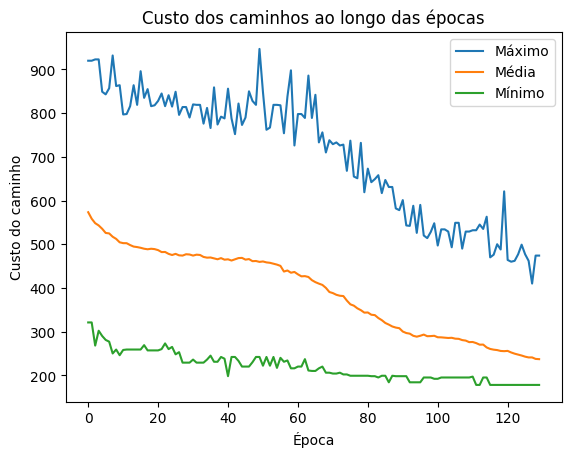

In [17]:
x = range(len(results[0]))

plt.plot(x, results[1], label='Máximo')
plt.plot(x, results[2], label='Média')
plt.plot(x, results[0], label='Mínimo')
plt.xlabel('Época')
plt.ylabel('Custo do caminho')
plt.title('Custo dos caminhos ao longo das épocas')
plt.legend(loc='best')
plt.show()